<a href="https://colab.research.google.com/github/Divyanshu451/Natural-Language-Processing-with-Disaster-Tweets/blob/main/NLP_disaster_tweets_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import tensorflow as tf

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving train.csv to train (1).csv


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving test.csv to test (1).csv


In [ ]:
train_df = pd.read_csv("train.csv")
test_df =  pd.read_csv("test.csv")

Unique keywords num=222
Unique keywords num=222


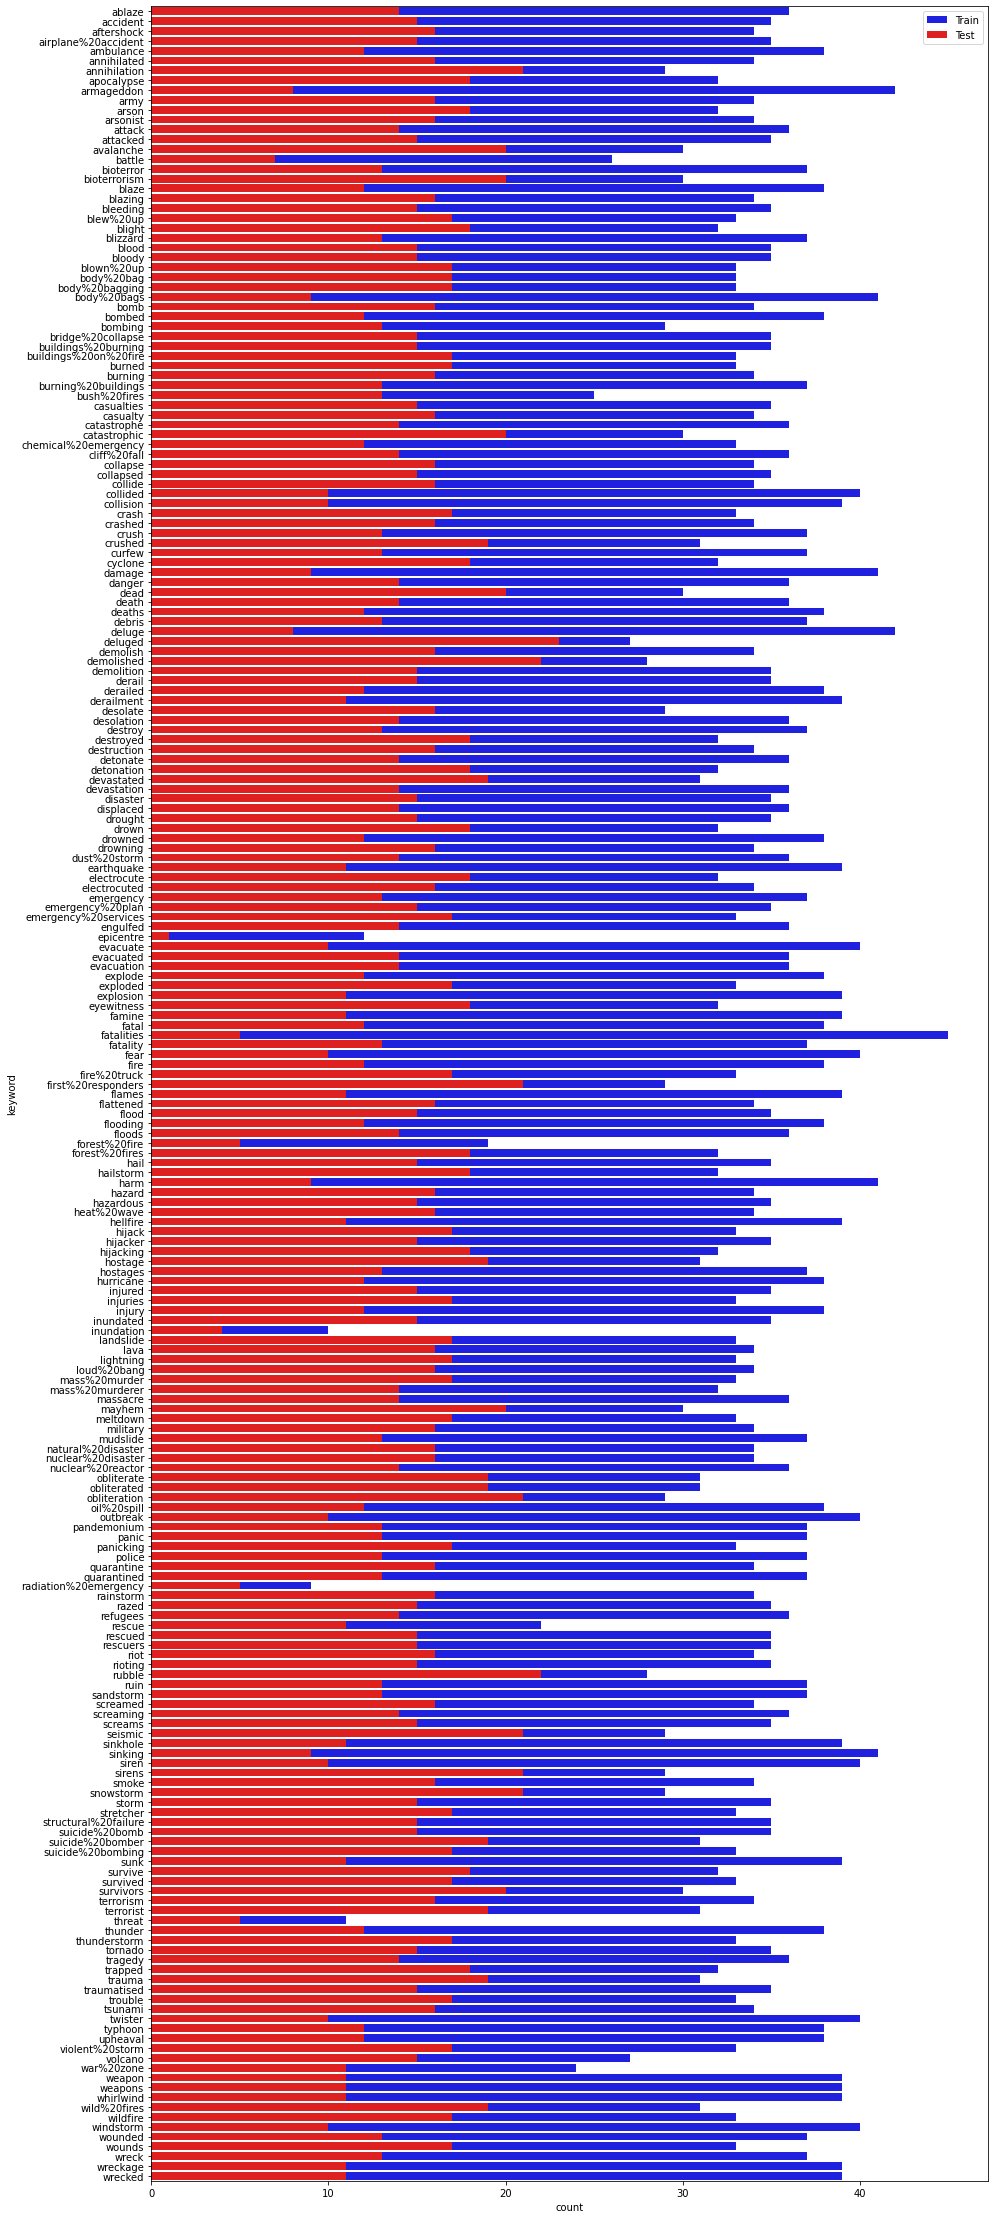

In [ ]:
plt.figure(figsize=(15,40))
print(f'Unique keywords num={len(train_df.keyword.unique())}')
print(f'Unique keywords num={len(test_df.keyword.unique())}')
sns.countplot(y=train_df['keyword'], color=(0,0,1), label='Train')
sns.countplot(y=test_df['keyword'], color=(1,0,0), label='Test')
plt.legend()

In [ ]:
EMOJIS = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}
URLPATTERN        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
USERPATTERN       = '@[^\s]+'
SEQPATTERN   = r"(.)\1\1+"
SEQREPLACE = r"\1\1"

In [ ]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
wordLemm = WordNetLemmatizer()


In [ ]:
import re

def preprocess_text(text):
      #text = re.sub(r"http\S+", "", text)
    ### Replacing URL
    text = re.sub(URLPATTERN,' URL',text)
    ### Replacing EMOJI
    for emoji in EMOJIS.keys():
        text = text.replace(emoji, "EMOJI" + EMOJIS[emoji])  
    ### Replacing USER pattern
    #text = re.sub(USERPATTERN,' URL',text)
    ### Removing non-alphabets
    #text = re.sub('[^a-zA-z]'," ",text)
    ### Removing consecutive letters
    #text = re.sub(SEQPATTERN,SEQREPLACE,text)
    #text = text.split()
    #text = [wordLemm.lemmatize(word) for word in text if not word in stopwords.words('english') and len(word) > 1]
    #text = ' '.join(text)
    return text

In [ ]:
!pip install -U tensorflow_text==2.3

In [ ]:
!pip install -q tf-models-official==2.3

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization

/usr/local/lib/python3.7/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.4.0 and strictly below 2.7.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.3.4 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [ ]:
batch_size = 32
seed = 42
train_ds = tf.data.Dataset.from_tensor_slices((train_df['text'].tolist(),train_df['target'].tolist())).batch(batch_size)


In [ ]:
bert_model_name = 'bert_en_uncased_L-12_H-768_A-12'

In [ ]:
tfhub_handle_encoder ='https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2'

In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation= "sigmoid" , name='classifier')(net)
  return tf.keras.Model(text_input, net)

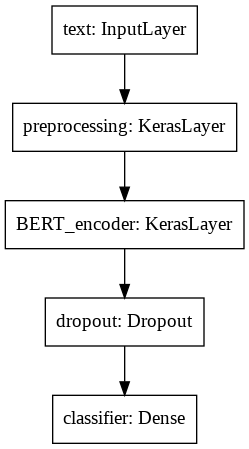

In [ ]:

classifier_model = build_classifier_model()
tf.keras.utils.plot_model(classifier_model)

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [ ]:
epochs = 20
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:

classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:

print(f'Training model with {tfhub_handle_encoder}')
#history = classifier_model.fit(x=train_ds, validation_data=valid_ds, epochs=epochs)
history = classifier_model.fit(x=train_ds, epochs=epochs)

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 1/20
238/238 [==============================] - 382s 2s/step - loss: 0.6704 - binary_accuracy: 0.6692
Epoch 2/20
238/238 [==============================] - 382s 2s/step - loss: 0.6168 - binary_accuracy: 0.7944
Epoch 3/20
238/238 [==============================] - 381s 2s/step - loss: 0.6051 - binary_accuracy: 0.8254
Epoch 4/20
238/238 [==============================] - 381s 2s/step - loss: 0.5962 - binary_accuracy: 0.8438
Epoch 5/20
238/238 [==============================] - 381s 2s/step - loss: 0.5971 - binary_accuracy: 0.8348
Epoch 6/20
238/238 [==============================] - 381s 2s/step - loss: 0.5954 - binary_accuracy: 0.8391
Epoch 7/20
238/238 [==============================] - 381s 2s/step - loss: 0.5849 - binary_accuracy: 0.8671
Epoch 8/20
238/238 [==============================] - 381s 2s/step - loss: 0.5803 - binary_accuracy: 0.8777
Epoch 9/20
238/238 [==============================] -

In [ ]:
probs = classifier_model.predict(test_df["text"]) 
threshold = 0.4
preds = np.where(probs[:,] > threshold, 1, 0)

In [ ]:
preds

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

In [ ]:

submission.to_csv('submission.csv', index=False, header=True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
sample=pd.read_csv('/content/drive/My Drive/Flickr_Data/sample_submission.csv')

In [ ]:
sample["target"]=preds

In [ ]:
sample.to_csv('/content/drive/My Drive/Flickr_Data/sample_submission2.csv', index=False, header=True)